## SETUP inicial
Aqui importamos as principais bibliotecas e definimos algumas configurações para a exploração dos dados. 
Vou utilizar um random state fixo de 42 para garantir a reprodutibilidade do modelo

### Objetivo
Desenvolver, treinar e avaliar modelos preditivos para estimar a probabilidade da variável target (y), utilizando os dados tratados no Notebook 2, respeitando a separação temporal e avaliando o desempenho por métricas adequadas ao problema de crédito.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


Aqui vamos importar os dados do notebook 2 já pré-processados

In [2]:
# Treino
df_mediana = pd.read_csv('../data/processed/treino_mediana.csv')
df_media = pd.read_csv('../data/processed/treino_media.csv')

# Validação
df_validacao_mediana = pd.read_csv('../data/processed/validacao_mediana.csv')
df_validacao_media = pd.read_csv('../data/processed/validacao_media.csv')

# Teste
df_teste_mediana = pd.read_csv('../data/processed/teste_mediana.csv')
df_teste_media = pd.read_csv('../data/processed/teste_media.csv')



Agora vamos definir algumas funções para separar as features da variavel target e para treinar o modelo e trazer as métricas.

In [3]:
def separa_xy(df):
    X = df.drop(columns=['id', 'safra', 'y'], errors='ignore')
    y = df['y']
    return X, y


In [4]:
def treinar_e_avaliar(X_train, y_train, X_valid, y_valid):
    model = LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        penalty='l2',  
        C=0.5         
    )
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    auc = roc_auc_score(y_valid, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    ks = max(tpr - fpr)
    gini = 2 * auc - 1
    
    return model, y_pred_proba, auc, ks, gini


In [5]:
pipelines = {
    'Mediana': (df_mediana, df_validacao_mediana, df_teste_mediana),
    'Média': (df_media, df_validacao_media, df_teste_media)
}

resultados = []

for nome, (df_train, df_valid, df_test) in pipelines.items():
    X_train, y_train = separa_xy(df_train)
    X_valid, y_valid = separa_xy(df_valid)
    
    model, y_pred, auc, ks, gini = treinar_e_avaliar(X_train, y_train, X_valid, y_valid)
    
    resultados.append({
        'Pipeline': nome,
        'AUC': auc,
        'KS': ks,
        'Gini': gini,
        'Modelo': model,
        'y_pred': y_pred,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': separa_xy(df_test)[0],
        'y_test': separa_xy(df_test)[1]
    })

resultados_df = pd.DataFrame(resultados)
resultados_df[['Pipeline', 'AUC', 'KS', 'Gini']]


c:\Users\rique\OneDrive\Desktop\credit_scoring\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\rique\OneDrive\Desktop\credit_scoring\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,Pipeline,AUC,KS,Gini
0,Mediana,0.747522,0.380514,0.495045
1,Média,0.746547,0.378684,0.493095


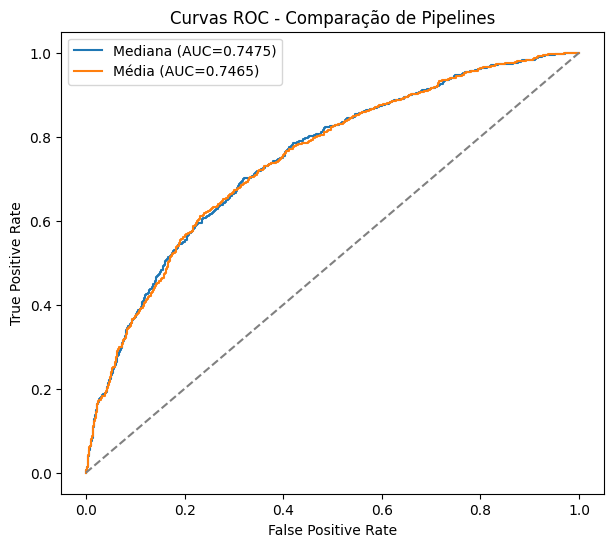

In [6]:
plt.figure(figsize=(7,6))

for i, row in resultados_df.iterrows():
    fpr, tpr, _ = roc_curve(separa_xy(pipelines[row['Pipeline']][1])[1], row['y_pred'])
    plt.plot(fpr, tpr, label=f"{row['Pipeline']} (AUC={row['AUC']:.4f})")

plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparação de Pipelines')
plt.legend()
plt.show()


In [7]:
melhor_idx = resultados_df['AUC'].idxmax()
melhor_pipeline = resultados_df.loc[melhor_idx, 'Pipeline']
melhor_modelo = resultados_df.loc[melhor_idx, 'Modelo']
X_train_best = resultados_df.loc[melhor_idx, 'X_train']
X_test_best = resultados_df.loc[melhor_idx, 'X_test']
y_test_best = resultados_df.loc[melhor_idx, 'y_test']

print(f"Melhor pipeline: {melhor_pipeline}")


Melhor pipeline: Mediana


In [8]:
resultados_df

,Pipeline,AUC,KS,Gini,Modelo,y_pred,X_train,y_train,X_test,y_test
0,Mediana,0.747522,0.380514,0.495045,"LogisticRegression(C=0.5, max_iter=1000, penal...","[0.07444377064331277, 0.19709609469698838, 0.2...",VAR_1 VAR_6 VAR_28 VAR_19 ...,0 1 1 0 2 0 3 0 4 ...,VAR_1 VAR_6 VAR_28 VAR_19 ...,0 0 1 1 2 0 3 0 4 ...
1,Média,0.746547,0.378684,0.493095,"LogisticRegression(C=0.5, max_iter=1000, penal...","[0.0750034176046298, 0.19570833376921395, 0.16...",VAR_1 VAR_6 VAR_28 VAR_19 ...,0 1 1 0 2 0 3 0 4 ...,VAR_1 VAR_6 VAR_28 VAR_19 ...,0 0 1 1 2 0 3 0 4 ...


In [9]:
from sklearn.metrics import roc_auc_score, roc_curve

metricas_teste = []

for res in resultados:
    nome = res['Pipeline']
    modelo = res['Modelo']
    X_test = res['X_test']
    y_test = res['y_test']

    # Predição de probabilidade
    y_test_pred = modelo.predict_proba(X_test)[:, 1]

    # Métricas
    auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    ks_test = max(tpr_test - fpr_test)
    gini_test = 2 * auc_test - 1

    metricas_teste.append({
        'Pipeline': nome,
        'AUC_teste': auc_test,
        'KS_teste': ks_test,
        'Gini_teste': gini_test
    })

    print(f'Pipeline: {nome}')
    print(f'AUC (teste): {auc_test:.4f}')
    print(f'KS (teste): {ks_test:.4f}')
    print(f'Gini (teste): {gini_test:.4f}')
    print('-' * 40)


Pipeline: Mediana
AUC (teste): 0.7017
KS (teste): 0.3114
Gini (teste): 0.4035
----------------------------------------
Pipeline: Média
AUC (teste): 0.6982
KS (teste): 0.2972
Gini (teste): 0.3964
----------------------------------------


In [10]:
# Mediana
y_test_pred = melhor_modelo.predict_proba(X_test_best)[:, 1]

auc_test = roc_auc_score(y_test_best, y_test_pred)
fpr_test, tpr_test, _ = roc_curve(y_test_best, y_test_pred)
ks_test = max(tpr_test - fpr_test)
gini_test = 2 * auc_test - 1

print(f"AUC (teste): {auc_test:.4f}")
print(f"KS (teste): {ks_test:.4f}")
print(f"Gini (teste): {gini_test:.4f}")

# Media

# Mediana + Flag



AUC (teste): 0.7017
KS (teste): 0.3114
Gini (teste): 0.4035


In [11]:
pd.Series(modelo.coef_[0], index=X_train.columns)\
  .sort_values(key=abs, ascending=False)\
  .head(80)



VAR_9    -1.033557
VAR_1    -1.030401
VAR_20   -0.762437
VAR_24   -0.463395
VAR_32   -0.433011
VAR_72    0.298722
VAR_53   -0.208835
VAR_6    -0.189990
VAR_30   -0.185734
VAR_19   -0.174562
VAR_58   -0.163270
VAR_54   -0.123495
VAR_65   -0.096950
VAR_4     0.055928
VAR_28   -0.053561
VAR_57   -0.015686
VAR_40    0.000601
dtype: float64

In [12]:
coef_df = pd.DataFrame({
    'Variável': X_train_best.columns,
    'Coeficiente': melhor_modelo.coef_[0]
}).sort_values('Coeficiente', key=abs, ascending=False)

coef_df.head(10)


,Variável,Coeficiente
0,VAR_1,-1.036285
8,VAR_9,-1.015563
10,VAR_20,-0.764402
15,VAR_24,-0.552947
4,VAR_32,-0.386899
14,VAR_72,0.363879
13,VAR_30,-0.248228
12,VAR_53,-0.225273
3,VAR_19,-0.165177
1,VAR_6,-0.161725
